# Homogenization Model

## Example - Fe-Cr-Ni system

The homogenization model can simulate multiphase diffusion without having to resort to more complex methods such as phase field modeling. The model relies on the assumption that every volume element is in local equilibrium. Then fluxes are determined by the mobility and chemical potential gradient.

$$ J_k = -\Gamma_k^* \frac{\partial \mu_k^{eq}}{\partial z} $$

$$ \Gamma_k^\phi = M_k^\phi x_k^\phi $$

$$ \Gamma_k^* = f(\Gamma_k^\alpha, \Gamma_k^\beta, ...) $$

$\Gamma_k^*$ is an average mobility term that assumes certain geometry in the system. The following averaging functions are available in kawin:

1. Upper Wiener - assumes phases are continuous layers parallel to flux
2. Lower Wiener - assumes phases are continuous layers orthogonal to flux
3. Upper Hashin-Shtrikman - assumes a matrix of the phase with the fastest mobility with spheres of all other phases
4. Lower Hashin-Shtrikman - assumes a matrix of the phase with the slowest mobility with spheres of all other phases
5. Labyrinth - assumes phases as precipitates

Note that the Hashin-Shtrikman bounds are much narrower than the Wiener bounds.

The fluxes are calculated in a lattice fixed frame of reference. To convert to a volume fixed frame, the flux is then defined by:

$$ J_k^v = J_k - x_k \sum{J_j} $$

In this example a Fe-25.7Cr-6.5Ni / Fe-42.3Cr-27.6Ni diffusion couple will be simulated using the lower and upper Hashin-Shtrikman bounds. Both sides of the diffusion couple are $\alpha+\gamma$.

The first step is the load the thermodynamic database.

In [4]:
from kawin.Thermodynamics import GeneralThermodynamics
from kawin.diffusion.Homogenization import HomogenizationModel
import matplotlib.pyplot as plt

elements = ['FE', 'CR', 'NI']
phases = ['FCC_A1', 'BCC_A2']

therm = GeneralThermodynamics('FeCrNi.tdb', elements, phases)

Defining the homogenization model is similar to defining the single phase diffusion model where the bounds of the domain, the number of volume elements, the defined elements and the defined phases are needed.

As with the single phase diffusion model, inputting the composition profile and parameters are also the same. The only difference is that two extra parameters will be defined for the homogenization model:

Smoothing factor ($\varepsilon$) - this factor allows for the composition to smooth out when the chemical potential gradient is zero but the composition gradient is non-zero (in n-phase regions where n is the number of components). This can be viewed as an ideal contribution where the composition smoothes out to maximize entropy. By default, it is set to 0.05, but here, we will set it to 0.01.

Mobility function - this defined which of the above mentioned mobility functions to use. We will start with the lower Hashin-Shtrikman bounds.

Solving the model is also similar to the single phase diffusion model.

In [5]:
ml = HomogenizationModel([-5e-4, 5e-4], 200, elements, phases)
ml.setCompositionStep(0.257, 0.423, 0, 'CR')
ml.setCompositionStep(0.065, 0.276, 0, 'NI')
ml.setTemperature(1100+273.15)
ml.setThermodynamics(therm)
ml.eps = 0.01

ml.setMobilityFunction('hashin lower')
ml.solve(100*3600, True, 500)

Iteration	Sim Time (h)	Run time (s)
0		0.000		0.000
252		100.000		19.948


The next model will be the exact same except the mobility function will be switched to the upper Hashin-Shtrikman bounds.

In [6]:
mu = HomogenizationModel([-5e-4, 5e-4], 200, elements, phases)
mu.setCompositionStep(0.257, 0.423, 0, 'CR')
mu.setCompositionStep(0.065, 0.276, 0, 'NI')
mu.setTemperature(1100+273.15)
mu.setThermodynamics(therm)
ml.eps = 0.01

mu.setMobilityFunction('hashin upper')
mu.solve(100*3600, True, 500)

Iteration	Sim Time (h)	Run time (s)
0		0.000		0.000
500		12.904		32.985
1000		27.554		51.484
1500		42.084		63.857
2000		56.576		72.025
2500		70.924		78.078
3000		85.540		84.303
3500		99.884		89.262
3504		100.000		89.355


To compare the two mobility functions, the Cr composition, Ni composition and $\alpha$ phase fraction profile will be plotted. By default, the plotting functions will plot all components or phases; however, an individual component or phase can be defined to have it be the only thing that is plotted.

Here, we can see that the upper Hashin-Shtrikman bounds gives a smoother Cr and Ni profile. Additionally, the lower Hashin-Shtrikman bounds shows a pure $\gamma$ layer near the interface of around 4-6 $\mu m$.

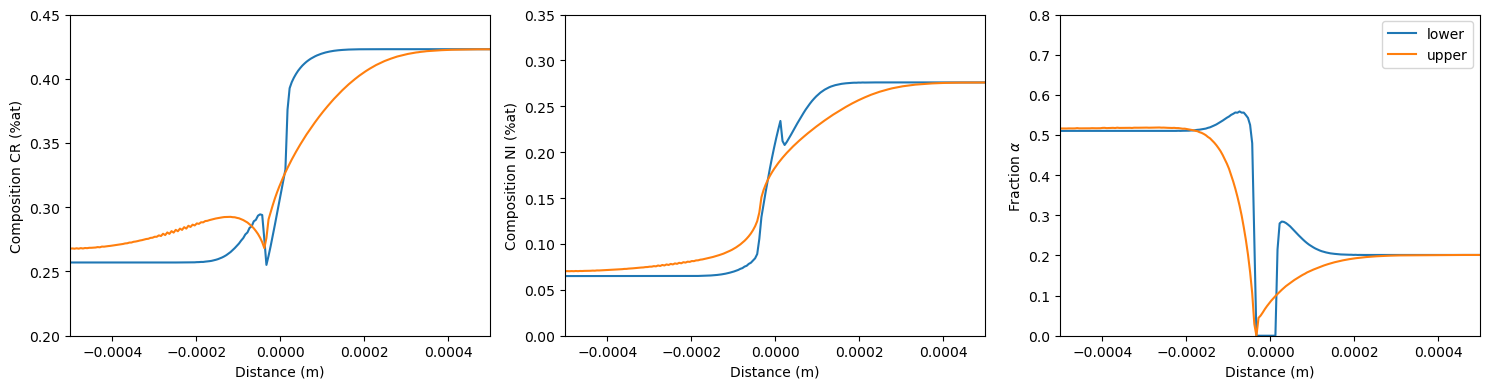

In [7]:
import numpy as np

fig, ax = plt.subplots(1,3, figsize=(15,4))
ml.plot(ax[0], plotElement='CR', label='lower')
ml.plot(ax[1], plotElement='NI', label='lower')
ml.plotPhases(ax[2], plotPhase='BCC_A2', label='lower')

mu.plot(ax[0], plotElement='CR', label='upper')
mu.plot(ax[1], plotElement='NI', label='upper')
mu.plotPhases(ax[2], plotPhase='BCC_A2', label='upper')

ax[0].set_ylabel('Composition CR (%at)')
ax[0].set_ylim([0.2, 0.45])
ax[1].set_ylabel('Composition NI (%at)')
ax[1].set_ylim([0, 0.35])
ax[2].set_ylabel(r'Fraction $\alpha$')
ax[2].set_ylim([0, 0.8])
plt.tight_layout()
plt.show()

We can plot the composition profile on a phase diagram to further show the diffusion path and compare both mobility functions. Using the triangular plotting feature in pycalphad, the Fe-Cr-Ni ternary phase diagram can be plotted and the diffusion paths of the two homogenization models can be superimposed on top.

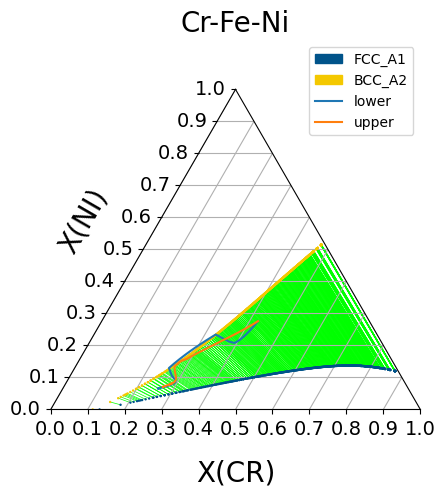

In [8]:
from pycalphad import equilibrium, Database, ternplot, variables as v
from pycalphad.plot import triangular
from pycalphad.plot.utils import phase_legend

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='triangular')

conds = {v.T: 1100+273.15, v.P:101325, v.X('CR'): (0,1,0.015), v.X('NI'): (0,1,0.015)}
ternplot(therm.db, ['FE', 'CR', 'NI', 'VA'], phases, conds, x=v.X('CR'), y=v.X('NI'), ax = ax)

ln1, = ax.plot(ml.getX('CR'), ml.getX('NI'), label='lower')
ln2, = ax.plot(mu.getX('CR'), mu.getX('NI'), label='upper')

#The pycalphad ternplot function will automatically add a legend for the phases,
#but the legend has to be added again to add labels for the diffusion paths
handles, _ = phase_legend(phases)
ax.legend(handles = handles + [ln1, ln2])

plt.show()

## References

1. H. Larsson and L. Hoglund, "Multiphase diffusion simulations in 1D using the DICTRA homogenization model" *Calphad* 33 (2009) p. 495
2. H. Larsson and A. Engstrom, "A homogenization approach to diffusion simulations applied to $\alpha+\gamma$ Fe-Cr-Ni diffusion couples" *Acta Materialia* 54 (2006) p. 2431